# Medicare Provider Payments and Service Utilization Analysis

This notebook explores the **CMS Medicare Physician & Other Practitioners (2023)** dataset.  
We will analyze provider utilization, charges, and Medicare payments across **specialties, states, and providers**.

**Goals:**
- Identify specialties, providers, and states driving the largest share of Medicare payments.
- Compare submitted charges to Medicare payments and measure reimbursement efficiency.
- Visualize geographic and specialty-level spending patterns and surface actionable insights.

**Data:** Medicare Physician & Other Practitioners - by Provider and Service (2023), CSV (~3GB, ~9.6M rows).

**Table of contents**
1. Setup & imports
2. Initial inspection
3. Load & clean data
4. Feature engineering & aggregations (calculations)
5. Metrics
6. Visualizations
7. KPIs & summary tables
8. Key Findings and Insights
9. Conclusion

## 1. Setup & imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px
import plotly.io as pio

# Pandas settings
pd.options.mode.copy_on_write = True  # pandas 2.x: safer edits, less memory churn
pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_columns', 100)
pd.set_option("display.width", 160)

# Path to data
DATA_PATH = "../data/input/MUP_PHY_R25_P05_V20_D23_Prov_Svc.csv"

## 2. Initial inspection

In [2]:
sample = pd.read_csv(
    DATA_PATH,
    nrows=1000,
    low_memory=False
)
sample.info(memory_usage="deep")
sample.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Rndrng_NPI                     1000 non-null   int64  
 1   Rndrng_Prvdr_Last_Org_Name     1000 non-null   object 
 2   Rndrng_Prvdr_First_Name        957 non-null    object 
 3   Rndrng_Prvdr_MI                654 non-null    object 
 4   Rndrng_Prvdr_Crdntls           944 non-null    object 
 5   Rndrng_Prvdr_Ent_Cd            1000 non-null   object 
 6   Rndrng_Prvdr_St1               1000 non-null   object 
 7   Rndrng_Prvdr_St2               308 non-null    object 
 8   Rndrng_Prvdr_City              1000 non-null   object 
 9   Rndrng_Prvdr_State_Abrvtn      1000 non-null   object 
 10  Rndrng_Prvdr_State_FIPS        1000 non-null   int64  
 11  Rndrng_Prvdr_Zip5              1000 non-null   int64  
 12  Rndrng_Prvdr_RUCA              1000 non-null   fl

,Rndrng_NPI,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_MI,Rndrng_Prvdr_Crdntls,Rndrng_Prvdr_Ent_Cd,Rndrng_Prvdr_St1,Rndrng_Prvdr_St2,Rndrng_Prvdr_City,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_State_FIPS,Rndrng_Prvdr_Zip5,Rndrng_Prvdr_RUCA,Rndrng_Prvdr_RUCA_Desc,Rndrng_Prvdr_Cntry,Rndrng_Prvdr_Type,Rndrng_Prvdr_Mdcr_Prtcptg_Ind,HCPCS_Cd,HCPCS_Desc,HCPCS_Drug_Ind,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt
0,1003000126,Enkeshafi,Ardalan,NaN,M.D.,I,6410 Rockledge Dr Ste 304,NaN,Bethesda,MD,24,20817,1.00,Metropolitan area core: primary flow within an...,US,Hospitalist,Y,99221,Initial hospital care with straightforward or ...,N,F,12,12.00,12,250.23,89.06,60.31,54.67
1,1003000126,Enkeshafi,Ardalan,NaN,M.D.,I,6410 Rockledge Dr Ste 304,NaN,Bethesda,MD,24,20817,1.00,Metropolitan area core: primary flow within an...,US,Hospitalist,Y,99222,Initial hospital care with straightforward or ...,N,F,22,22.00,22,318.58,130.31,99.38,98.43
2,1003000126,Enkeshafi,Ardalan,NaN,M.D.,I,6410 Rockledge Dr Ste 304,NaN,Bethesda,MD,24,20817,1.00,Metropolitan area core: primary flow within an...,US,Hospitalist,Y,99231,Subsequent hospital care with straightforward ...,N,F,76,127.00,127,95.73,54.82,43.56,38.75


## 3. Load & clean data

In [3]:
# Select relevant columns
USECOLS = [
    "Rndrng_NPI",
    "Rndrng_Prvdr_State_Abrvtn",
    "Rndrng_Prvdr_Type",
    "Rndrng_Prvdr_Mdcr_Prtcptg_Ind",
    "HCPCS_Cd",
    "HCPCS_Desc",
    "HCPCS_Drug_Ind",
    "Place_Of_Srvc",
    "Tot_Benes",
    "Tot_Srvcs",
    "Tot_Bene_Day_Srvcs",
    "Avg_Sbmtd_Chrg",
    "Avg_Mdcr_Alowd_Amt",
    "Avg_Mdcr_Pymt_Amt",
    "Avg_Mdcr_Stdzd_Amt",
]

# Dtypes to compress memory
DTYPES = {
    "Rndrng_NPI": "int64",
    "Rndrng_Prvdr_State_Abrvtn": "category",
    "Rndrng_Prvdr_Type": "category",
    "Rndrng_Prvdr_Mdcr_Prtcptg_Ind": "category",
    "HCPCS_Cd": "string",                  # codes should be string
    "HCPCS_Desc": "string",
    "HCPCS_Drug_Ind": "category",
    "Place_Of_Srvc": "category",
    "Tot_Benes": "int64",
    "Tot_Srvcs": "int64",
    "Tot_Bene_Day_Srvcs": "int64",
    "Avg_Sbmtd_Chrg": "float64",
    "Avg_Mdcr_Alowd_Amt": "float64",
    "Avg_Mdcr_Pymt_Amt": "float64",
    "Avg_Mdcr_Stdzd_Amt": "float64",
}

# Load in chunks to manage memory
chunks = pd.read_csv(
    DATA_PATH,
    usecols=USECOLS,
    chunksize=200_000,
    low_memory=False
)

data_chunks = []
for i, current_chunk in enumerate(chunks, 1):
    data_chunks.append(current_chunk)
    if i % 10 == 0:
        print(f"[Chunk {i}] processed…")

df = pd.concat(data_chunks, ignore_index=True)

# Normalize strings & enforce dtype
for col, dtype in DTYPES.items():
    if col in df.columns:
        if dtype in ["string", "category"]:
            df[col] = df[col].astype("string").str.strip().str.upper()

df = df.astype(DTYPES)

# Downcast numerics to save memory
for col in df.select_dtypes(include=["int"]).columns:
    df[col] = pd.to_numeric(df[col], downcast="unsigned")

df.info(memory_usage="deep")

# Nulls
nulls = df.isna().mean().sort_values(ascending=False) * 100
print(f"Null % (top 15):")
print(nulls[nulls > 0].head(15))

# Duplicates (NPI, HCPCS, Place_of_service should usually be unique)
dup_count = df.duplicated(subset=["Rndrng_NPI","HCPCS_Cd","Place_Of_Srvc"]).sum()
dup_pct = dup_count / len(df) * 100
print(f"Duplicate rows: {dup_count} ({dup_pct:.2f}%)")

# Drop duplicates
if dup_count > 0:
    df = df.drop_duplicates(subset=["Rndrng_NPI","HCPCS_Cd","Place_Of_Srvc"])

# Domain checks
def violations_summary(d):
    v = {}
    # Expected: Paid ≤ Allowed ≤ Submitted (on average)
    v["paid > allowed"] = int((d["Avg_Mdcr_Pymt_Amt"] > d["Avg_Mdcr_Alowd_Amt"]).sum())
    v["allowed > submitted"] = int((d["Avg_Mdcr_Alowd_Amt"] > d["Avg_Sbmtd_Chrg"]).sum())
    # Counts should be non-negative
    v["neg_services"] = int((d["Tot_Srvcs"] < 0).sum())
    v["neg_benes"] = int((d["Tot_Benes"] < 0).sum())
    v["neg_bene_day"] = int((d["Tot_Bene_Day_Srvcs"] < 0).sum())
    # Cardinality checks (just counts, not raw values)
    v["unique_place_values"] = d["Place_Of_Srvc"].nunique(dropna=True)
    v["unique_drug_ind_values"] = d["HCPCS_Drug_Ind"].nunique(dropna=True)
    # Logical consistency
    v["services < benes"] = int((d["Tot_Srvcs"] < d["Tot_Benes"]).sum())
    v["zero_services"] = int((d["Tot_Srvcs"] == 0).sum())
    return v

print("Violations summary:")
print(violations_summary(df))

[Chunk 10] processed…
[Chunk 20] processed…
[Chunk 30] processed…
[Chunk 40] processed…
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9660647 entries, 0 to 9660646
Data columns (total 15 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   Rndrng_NPI                     uint32  
 1   Rndrng_Prvdr_State_Abrvtn      category
 2   Rndrng_Prvdr_Type              category
 3   Rndrng_Prvdr_Mdcr_Prtcptg_Ind  category
 4   HCPCS_Cd                       string  
 5   HCPCS_Desc                     string  
 6   HCPCS_Drug_Ind                 category
 7   Place_Of_Srvc                  category
 8   Tot_Benes                      uint32  
 9   Tot_Srvcs                      uint32  
 10  Tot_Bene_Day_Srvcs             uint32  
 11  Avg_Sbmtd_Chrg                 float64 
 12  Avg_Mdcr_Alowd_Amt             float64 
 13  Avg_Mdcr_Pymt_Amt              float64 
 14  Avg_Mdcr_Stdzd_Amt             float64 
dtypes: category(5), float64(4), s

## 4. Feature engineering & aggregations (calculations)

The raw data, with its millions of rows, is too granular to draw meaningful conclusions. To understand trends and patterns, we need to create new, more useful metrics and aggregate the data. This process allows us to shift from a provider-by-service view to a more strategic, high-level perspective.

I first created per-row totals to get a complete picture of the financial transactions for each service. This is the foundational step before any higher-level analysis, ensuring all subsequent aggregations are based on accurate sums.

In [4]:
# Derived totals (per row)
df = df.assign(
    Total_Sbmtd_Chrg = df["Avg_Sbmtd_Chrg"] * df["Tot_Srvcs"],
    Total_Mdcr_Alowd = df["Avg_Mdcr_Alowd_Amt"] * df["Tot_Srvcs"],
    Total_Mdcr_Paid  = df["Avg_Mdcr_Pymt_Amt"]  * df["Tot_Srvcs"],
)

Analyzing the raw data by total services or payments can be misleading, as some providers see many more patients than others. Calculating metrics like paid per beneficiary and services per beneficiary allows for a more equitable comparison of utilization and cost across different providers or specialties. It normalizes the data by the number of unique patients, giving us a clearer picture of per-person spending.

In [5]:
# Per-beneficiary metrics (only where Tot_Benes > 0)
df = df.assign(
    paid_per_bene      = df["Total_Mdcr_Paid"]   / df["Tot_Benes"].replace(0, np.nan),
    submitted_per_bene = df["Total_Sbmtd_Chrg"]  / df["Tot_Benes"].replace(0, np.nan),
    services_per_bene  = df["Tot_Srvcs"]         / df["Tot_Benes"].replace(0, np.nan),
    reimb_ratio        = (df["Total_Mdcr_Paid"] / df["Total_Sbmtd_Chrg"]).clip(upper=10)
)

The reimbursement ratio (total paid / total submitted) is a crucial metric for evaluating efficiency. However, a simple average of this ratio across all providers would be heavily skewed by small-volume providers with unusual billing. I used a weighted mean (weighted by total services) to ensure that the ratio accurately reflects the efficiency of the most active providers, providing a more robust and reliable metric.

In [6]:
# Reimbursement ratio
df["reimb_ratio"] = df["Total_Mdcr_Paid"] / df["Total_Sbmtd_Chrg"]

To address the project's core goals, I aggregated the data by specialty and state. This transformation is essential for identifying the major drivers of Medicare spending. It allows us to pinpoint which medical fields and geographic regions are responsible for the largest share of payments and to compare their efficiency, directly answering our initial questions.

In [7]:
def aggregate_payments(df, group_col: str):
    agg = (
        df.groupby(group_col, observed=True)
          .agg(
              providers=("Rndrng_NPI", "nunique"),
              tot_benes=("Tot_Benes", "sum"),   # note: overcounts possible
              tot_srvcs=("Tot_Srvcs", "sum"),
              total_paid=("Total_Mdcr_Paid", "sum"),
              total_allowed=("Total_Mdcr_Alowd", "sum"),
              total_submitted=("Total_Sbmtd_Chrg", "sum"),
          )
          .reset_index()
    )

    # Services-weighted means
    agg["w_mean_paid_per_service"] = agg["total_paid"] / agg["tot_srvcs"]
    agg["w_mean_submitted_per_service"] = agg["total_submitted"] / agg["tot_srvcs"]

    # Weighted reimbursement ratio (total paid / total submitted)
    agg["w_reimb_ratio"] = np.divide(
        agg["total_paid"], agg["total_submitted"],
        out=np.zeros_like(agg["total_paid"]), where=agg["total_submitted"] > 0
    )

    return agg


# Apply to both state and specialty
state_agg = aggregate_payments(df, "Rndrng_Prvdr_State_Abrvtn")
specialty_agg = aggregate_payments(df, "Rndrng_Prvdr_Type")

Save both the row-level cleaned/engineered dataset and the aggregated tables to CSV to load into Tableau.

In [8]:
df.to_csv("../data/output/medicare_cleaned.csv", index=False)

agg_cols = ["total_paid","total_allowed","total_submitted","w_mean_paid_per_service","w_mean_submitted_per_service","w_reimb_ratio"]
state_agg[agg_cols] = state_agg[agg_cols].round(4)
specialty_agg[agg_cols] = specialty_agg[agg_cols].round(4)

state_agg.to_csv("../data/output/state_aggregates.csv", index=False)
specialty_agg.to_csv("../data/output/specialty_aggregates.csv", index=False)

## 5. Metrics

In [9]:
total_providers = df["Rndrng_NPI"].nunique()
total_benes = df["Tot_Benes"].sum()
total_services = df["Tot_Srvcs"].sum()
total_submitted = df["Total_Sbmtd_Chrg"].sum()
total_allowed = df["Total_Mdcr_Alowd"].sum()
total_paid = df["Total_Mdcr_Paid"].sum()

avg_submitted_per_service = total_submitted / total_services
avg_paid_per_service = total_paid / total_services
avg_reimb_ratio = total_paid / total_submitted

metrics = pd.DataFrame({
    "Metric": [
        "Total Providers",
        "Total Beneficiaries",
        "Total Services",
        "Total Submitted Charges ($)",
        "Total Medicare Allowed ($)",
        "Total Medicare Payments ($)",
        "Avg Submitted per Service ($)",
        "Avg Medicare Payment per Service ($)",
        "Avg Reimbursement Ratio"
    ],
    "Value": [
        total_providers,
        total_benes,
        total_services,
        total_submitted,
        total_allowed,
        total_paid,
        avg_submitted_per_service,
        avg_paid_per_service,
        avg_reimb_ratio
    ]
})

metrics["Formatted"] = metrics.apply(
    lambda r: f"{r['Value']:,.0f}" if r['Metric'] in ["Total Providers", "Total Beneficiaries", "Total Services"]
    else f"${r['Value']:,.2f}" if "$" in r['Metric']
    else f"{r['Value']:.1%}",
    axis=1
)

display(metrics[["Metric", "Formatted"]])

,Metric,Formatted
0,Total Providers,"1,175,281"
1,Total Beneficiaries,"824,740,808"
2,Total Services,"2,645,585,357"
3,Total Submitted Charges ($),"$371,191,432,499.21"
4,Total Medicare Allowed ($),"$118,466,072,108.77"
5,Total Medicare Payments ($),"$93,721,023,261.09"
6,Avg Submitted per Service ($),$140.31
7,Avg Medicare Payment per Service ($),$35.43
8,Avg Reimbursement Ratio,25.2%


## 6. Visualizations

Visualizations are the most effective way to communicate complex data patterns. Each chart I created was designed to answer a specific question and bring a different facet of the data to life.

### 6.1 Bar: Top 20 Specialties Receiving Medicare Payments

This is a fundamental visualization for answering our primary question: 'Who is driving Medicare payments?' The bar chart provides a clear, at-a-glance view of the top specialties by total paid amount. It's the most direct way to show the concentration of spending and immediately highlights the top contributors.

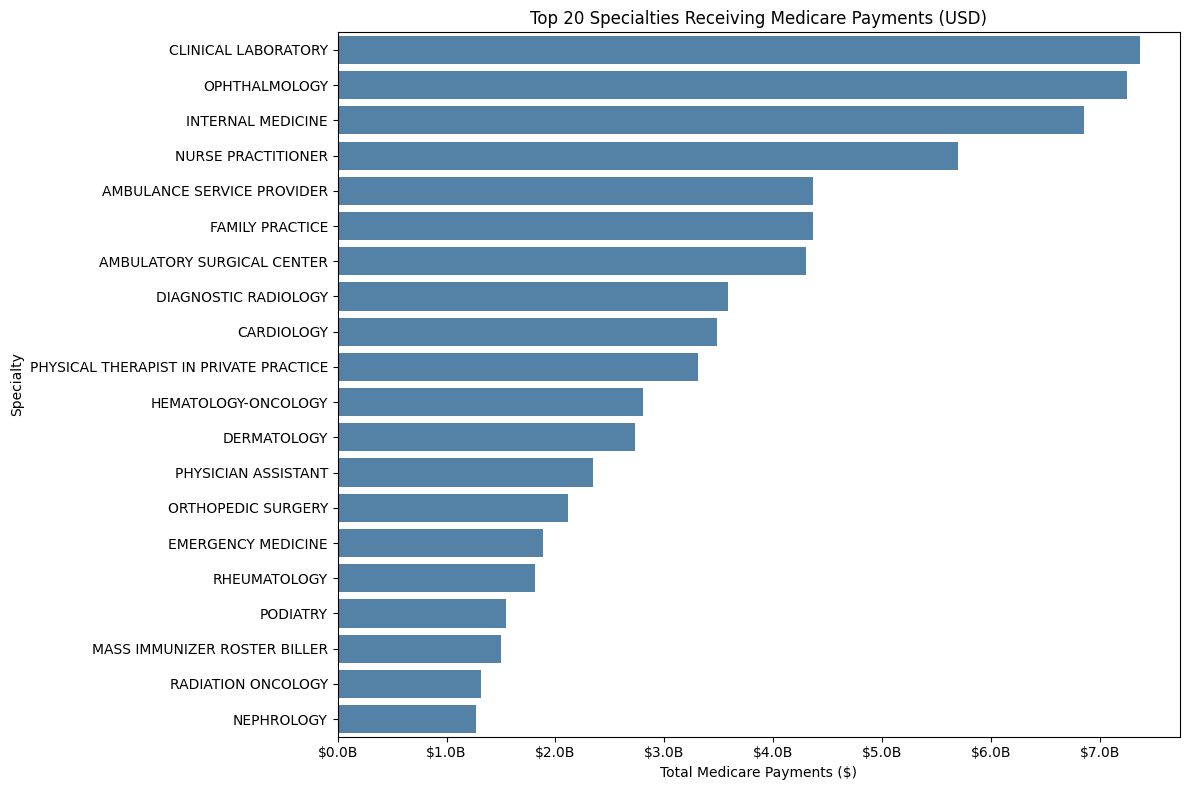

In [10]:
top_specs = specialty_agg.sort_values("total_paid", ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_specs,
    x="total_paid",
    y="Rndrng_Prvdr_Type",
    order=top_specs["Rndrng_Prvdr_Type"],
    color="steelblue"
)
plt.title("Top 20 Specialties Receiving Medicare Payments (USD)")
plt.xlabel("Total Medicare Payments ($)")
plt.ylabel("Specialty")

plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"${x/1e9:.1f}B"))

plt.tight_layout()
plt.show()

### 6.2 Boxplot: Top 20 Specialties by Weighted Reimbursement Ratio

I chose a boxplot to visualize the distribution of reimbursement ratios across different specialties. This chart is powerful because it not only shows the average ratio but also reveals the spread and outliers. This helps us identify specialties with consistently high or low efficiency and spot anomalies that might warrant further investigation.

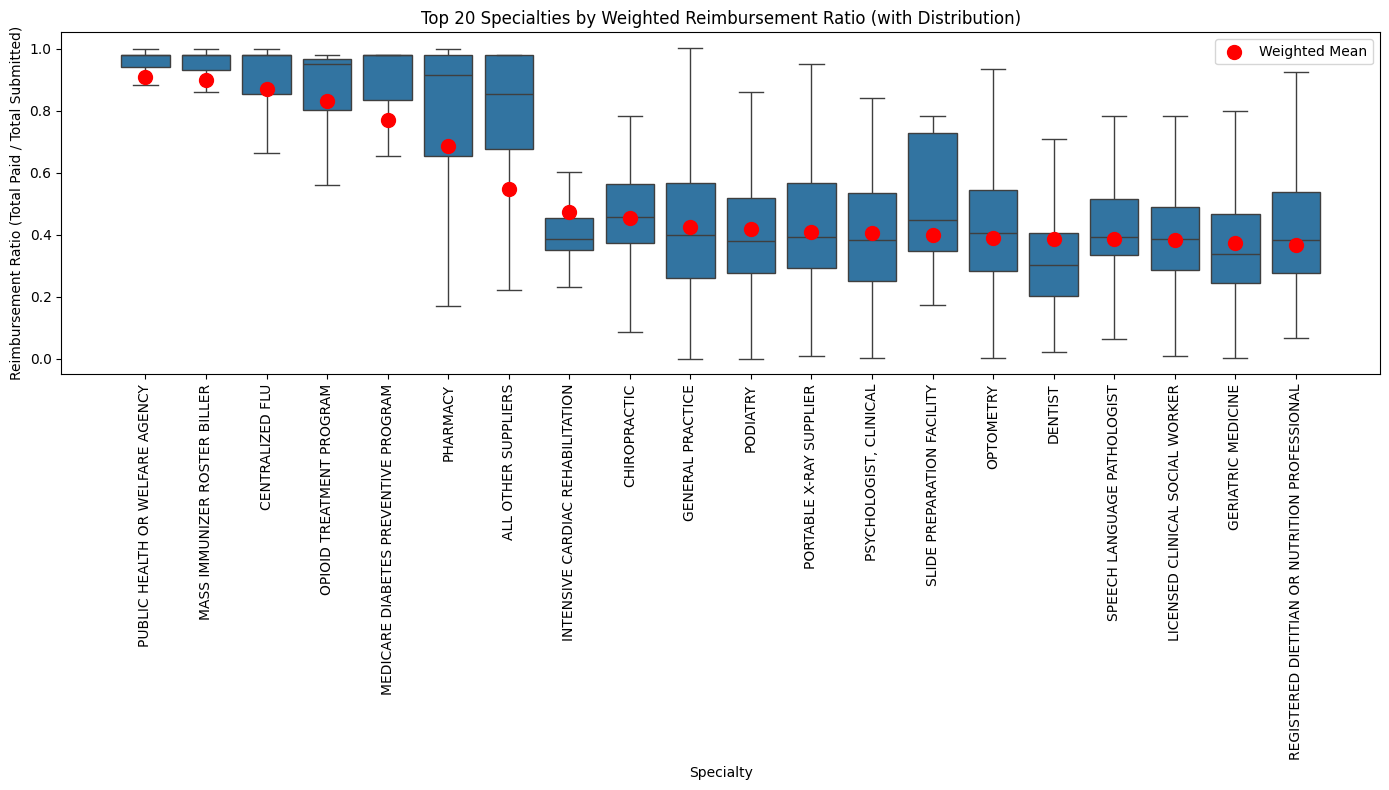

In [11]:
# Compute weighted reimbursement ratio and median per specialty
weighted = specialty_agg.set_index("Rndrng_Prvdr_Type")["w_reimb_ratio"]
medians = df.groupby("Rndrng_Prvdr_Type", observed=True)["reimb_ratio"].median()

# Take top 20 specialties by weighted ratio
top_specialties = weighted.sort_values(ascending=False).head(20).index

plt.figure(figsize=(14, 8))

# Boxplot of all individual ratios for top specialties
sns.boxplot(
    data=df[df["Rndrng_Prvdr_Type"].isin(top_specialties)],
    x="Rndrng_Prvdr_Type",
    y="reimb_ratio",
    order=top_specialties,
    showfliers=False,
)

# Overlay weighted mean as a red point
means = specialty_agg.set_index("Rndrng_Prvdr_Type")["w_reimb_ratio"]
for i, spec in enumerate(top_specialties):
    plt.scatter(i, means[spec], color="red", s=100, zorder=10, label="Weighted Mean" if i==0 else "")

plt.xticks(rotation=90)
plt.title("Top 20 Specialties by Weighted Reimbursement Ratio (with Distribution)")
plt.ylabel("Reimbursement Ratio (Total Paid / Total Submitted)")
plt.xlabel("Specialty")
plt.legend()
plt.tight_layout()
plt.show()


For the following 2 visualizations, I used a heatmap and choropleth map to show the geographic distribution of Medicare payments by state. These visualizations are perfect for revealing regional disparities in spending. They visually confirm that payments are concentrated in highly populated states like California, Florida, and Texas. It's a much more intuitive way to understand the data than just looking at a table of numbers.

### 6.3 Heatmap: State × Specialty

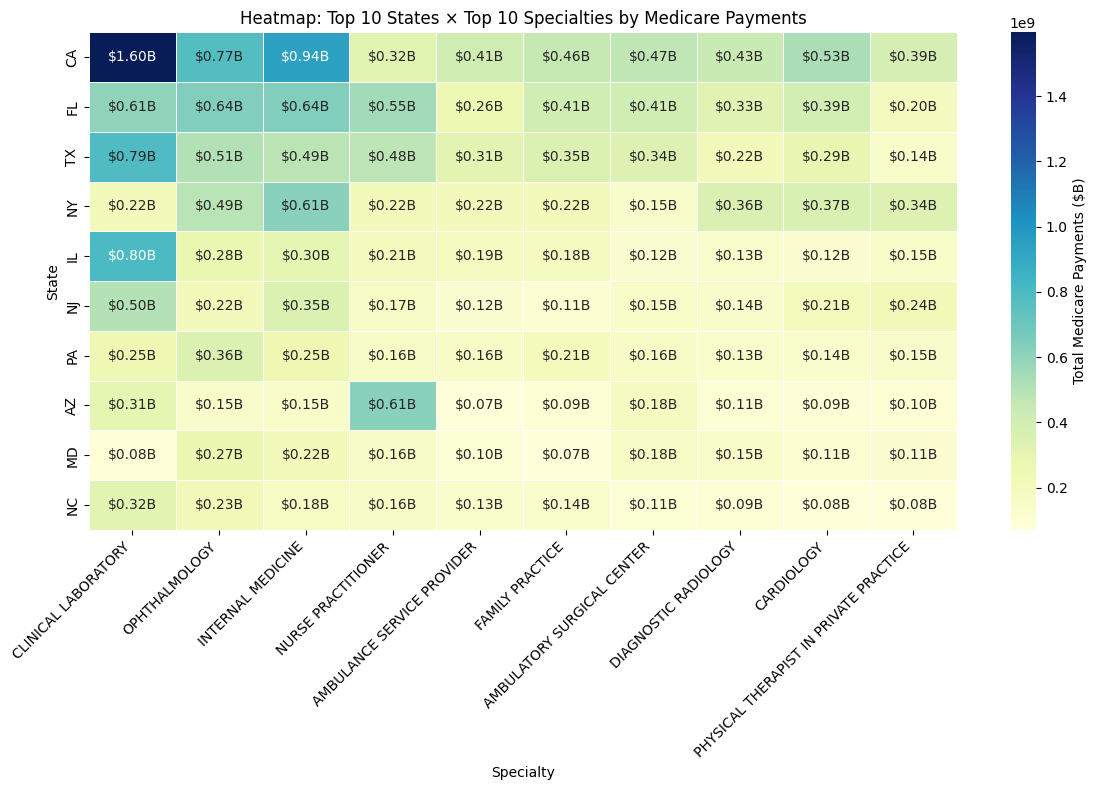

In [12]:
# Top 10 specialties by total Medicare payments
top_specs = df.groupby("Rndrng_Prvdr_Type", observed=True)["Total_Mdcr_Paid"].sum().nlargest(10).index

# Top 10 states by total Medicare payments
top_states = df.groupby("Rndrng_Prvdr_State_Abrvtn", observed=True)["Total_Mdcr_Paid"].sum().nlargest(10).index

# Pivot table filtered to top states and specialties
pivot_filtered = df.pivot_table(
    index="Rndrng_Prvdr_State_Abrvtn",
    columns="Rndrng_Prvdr_Type",
    values="Total_Mdcr_Paid",
    aggfunc="sum",
    observed=True
).loc[top_states, top_specs]

# Format values for annotations in billions ($B)
annot_values = pivot_filtered.map(lambda x: f"${x/1e9:.2f}B")

# Plot heatmap with log scale for color
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_filtered,
    annot=annot_values,
    fmt='',
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Total Medicare Payments ($B)'}
)
plt.title("Heatmap: Top 10 States × Top 10 Specialties by Medicare Payments")
plt.xlabel("Specialty")
plt.ylabel("State")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 6.4 Choropleth map: Total Medicare payments by state

In [13]:
pio.renderers.default = "browser"

fig = px.choropleth(
    state_agg,
    locations="Rndrng_Prvdr_State_Abrvtn",
    locationmode="USA-states",
    color="total_paid",
    color_continuous_scale="Blues",
    scope="usa",
    title="Total Medicare Payments by State (USD)"
)
fig.show()

### 6.5 Scatter: Submitted vs Paid by Specialty

I used a scatter plot to analyze the relationship between what was billed and what was paid. By adding a parity line, we can immediately spot providers who are billing significantly more than they are being paid. This is an excellent tool for outlier detection and helps us identify providers or specialties with unusually high or low reimbursement rates, which could be an area for further policy analysis.

I chose to add annotations to the scatter plot to specifically highlight specialties with high reimbursement ratios. This draws the reader's attention to the specific data points that represent our key finding—that high efficiency is rare and concentrated in a small subset of specialties. It turns the visualization into a powerful tool for storytelling and directly links the data to our conclusion.

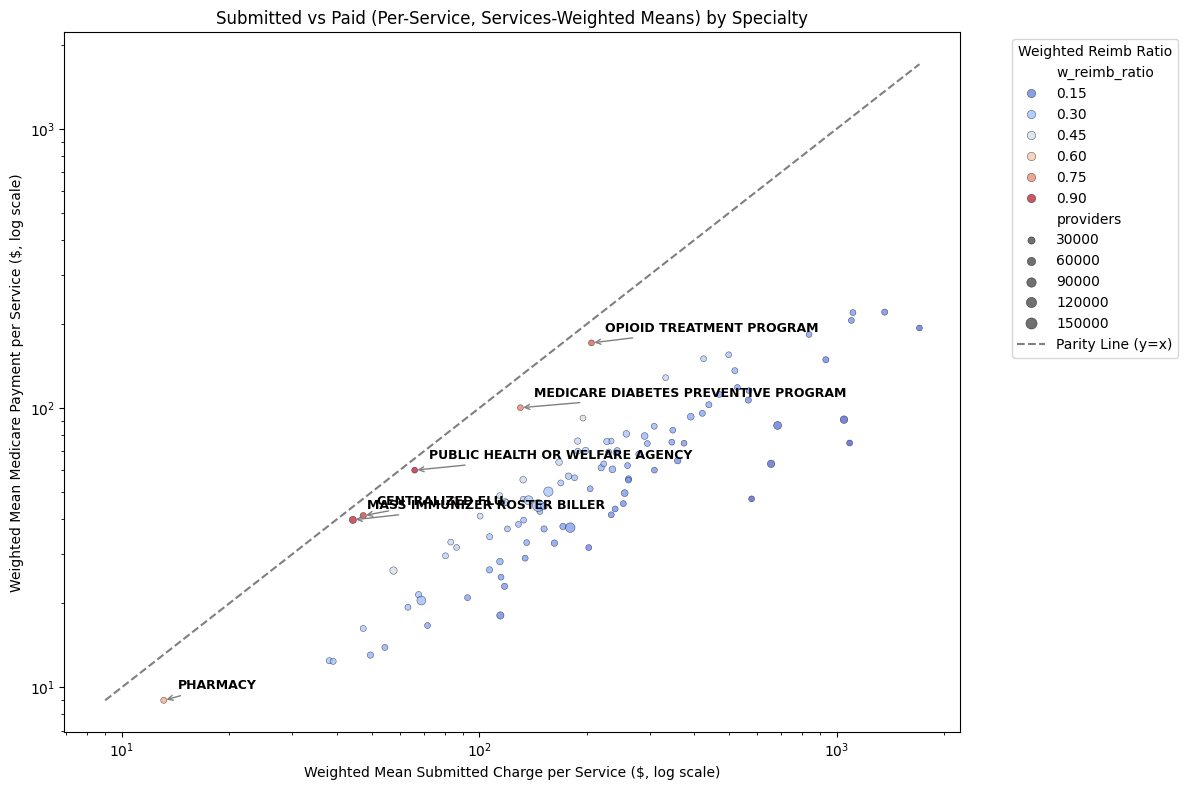

In [14]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=specialty_agg,
    x="w_mean_submitted_per_service",
    y="w_mean_paid_per_service",
    size="providers",
    hue="w_reimb_ratio",
    palette="coolwarm",
    alpha=0.7,
    edgecolor="k"
)

# Log scale for both axes
plt.xscale("log")
plt.yscale("log")

# Annotate specialties with w_reimb_ratio >= 60
high_ratio = specialty_agg[specialty_agg["w_reimb_ratio"] >= .60]
for _, row in high_ratio.iterrows():
    plt.annotate(
        row["Rndrng_Prvdr_Type"],
        (row["w_mean_submitted_per_service"], row["w_mean_paid_per_service"]),
        xytext=(10, 8), textcoords="offset points",
        fontsize=9, fontweight="bold",
        arrowprops=dict(arrowstyle="->", color="gray", lw=1)
    )

# Add parity line (y = x)
lims = [
    np.min([specialty_agg["w_mean_submitted_per_service"].min(), 
            specialty_agg["w_mean_paid_per_service"].min()]),
    np.max([specialty_agg["w_mean_submitted_per_service"].max(), 
            specialty_agg["w_mean_paid_per_service"].max()])
]
plt.plot(lims, lims, 'k--', alpha=0.5, label='Parity Line (y=x)')

plt.title("Submitted vs Paid (Per-Service, Services-Weighted Means) by Specialty")
plt.xlabel("Weighted Mean Submitted Charge per Service ($, log scale)")
plt.ylabel("Weighted Mean Medicare Payment per Service ($, log scale)")
plt.legend(title="Weighted Reimb Ratio", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## 7. KPIs & Summary Tables

### 7.1 Top States with the Highest Medicare Payments

In [15]:
top_states = state_agg.sort_values("total_paid", ascending=False).head(10)
top_states.rename(columns={
    "Rndrng_Prvdr_State_Abrvtn": "State",
    "providers": "Providers",
    "tot_benes": "Beneficiaries",
    "tot_srvcs": "Services",
    "total_submitted": "Total Submitted ($)",
    "total_allowed": "Total Allowed ($)",
    "total_paid": "Total Paid ($)",
    "w_reimb_ratio": "Weighted Reimbursement Ratio"
}, inplace=True)

display(top_states[[
    "State", "Providers", "Beneficiaries", "Services",
    "Total Submitted ($)", "Total Allowed ($)", "Total Paid ($)", "Weighted Reimbursement Ratio"
]].style.format({
    "Total Submitted ($)": "${:,.0f}",
    "Total Allowed ($)": "${:,.0f}",
    "Total Paid ($)": "${:,.0f}",
    "Weighted Reimbursement Ratio": "{:.1%}",
    "Providers": "{:,}",
    "Beneficiaries": "{:,}",
    "Services": "{:,}"
}))

,State,Providers,Beneficiaries,Services,Total Submitted ($),Total Allowed ($),Total Paid ($),Weighted Reimbursement Ratio
8,CA,"93,498","81,471,758","268,124,028","$44,266,088,289","$14,353,749,148","$11,525,455,735",26.0%
13,FL,"77,006","74,329,690","286,685,720","$33,327,507,269","$11,195,639,950","$8,883,415,882",26.7%
51,TX,"78,270","61,977,305","217,132,609","$30,166,113,072","$8,859,429,037","$7,074,719,346",23.4%
41,NY,"80,484","51,846,911","163,319,527","$27,327,541,950","$8,054,829,184","$6,347,958,091",23.2%
20,IL,"47,277","36,917,045","145,639,632","$16,609,666,882","$5,249,696,740","$4,262,580,511",25.7%
38,NJ,"36,541","41,878,323","117,720,150","$16,889,906,512","$4,801,460,978","$3,851,850,194",22.8%
45,PA,"58,065","31,661,062","110,690,727","$13,480,901,837","$4,782,477,115","$3,755,630,338",27.9%
7,AZ,"24,018","21,367,252","73,561,702","$10,605,533,878","$3,901,242,719","$3,106,083,686",29.3%
26,MD,"24,406","20,824,677","72,945,079","$9,751,372,521","$3,457,920,708","$2,706,273,168",27.8%
34,NC,"40,231","35,643,279","86,899,821","$10,891,802,831","$3,389,695,857","$2,692,010,853",24.7%


### 7.2 Top Specialties Receiving Medicare Payments

In [16]:
top_specialties = specialty_agg.sort_values("total_paid", ascending=False).head(10)
top_specialties.rename(columns={
    "Rndrng_Prvdr_Type": "Specialty",
    "providers": "Providers",
    "tot_benes": "Beneficiaries",
    "tot_srvcs": "Services",
    "total_submitted": "Total Submitted ($)",
    "total_allowed": "Total Allowed ($)",
    "total_paid": "Total Paid ($)",
    "w_reimb_ratio": "Weighted Reimbursement Ratio"
}, inplace=True)

display(top_specialties[[
    "Specialty", "Providers", "Beneficiaries", "Services",
    "Total Submitted ($)", "Total Allowed ($)", "Total Paid ($)", "Weighted Reimbursement Ratio"
]].style.format({
    "Total Submitted ($)": "${:,.0f}",
    "Total Allowed ($)": "${:,.0f}",
    "Total Paid ($)": "${:,.0f}",
    "Weighted Reimbursement Ratio": "{:.1%}",
    "Providers": "{:,}",
    "Beneficiaries": "{:,}",
    "Services": "{:,}"
}))

,Specialty,Providers,Beneficiaries,Services,Total Submitted ($),Total Allowed ($),Total Paid ($),Weighted Reimbursement Ratio
19,CLINICAL LABORATORY,"3,103","159,021,893","380,483,306","$24,039,344,462","$7,492,735,790","$7,365,996,708",30.6%
66,OPHTHALMOLOGY,"17,001","28,529,511","89,621,393","$23,124,971,715","$9,467,217,124","$7,246,047,696",31.3%
45,INTERNAL MEDICINE,"88,703","60,814,096","136,564,720","$21,319,918,129","$8,828,637,670","$6,856,443,874",32.2%
63,NURSE PRACTITIONER,"174,681","46,739,912","127,123,084","$18,599,474,765","$7,433,308,551","$5,693,318,948",30.6%
5,AMBULANCE SERVICE PROVIDER,"9,332","12,170,285","115,953,225","$19,888,038,268","$5,521,702,109","$4,367,981,204",22.0%
28,FAMILY PRACTICE,"78,514","48,395,779","93,311,228","$12,825,219,341","$5,721,359,917","$4,361,954,965",34.0%
6,AMBULATORY SURGICAL CENTER,"5,353","4,612,580","19,482,340","$26,549,197,621","$5,371,189,302","$4,298,258,792",16.2%
25,DIAGNOSTIC RADIOLOGY,"31,554","77,223,917","198,383,952","$22,728,576,435","$4,519,110,909","$3,588,173,382",15.8%
11,CARDIOLOGY,"19,399","36,759,993","57,772,858","$13,624,668,050","$4,598,427,404","$3,485,495,445",25.6%
79,PHYSICAL THERAPIST IN PRIVATE PRACTICE,"73,457","19,054,795","161,789,617","$11,143,576,023","$4,291,927,857","$3,310,403,894",29.7%


### 7.3 Specialties with High Reimbursement Ratio (>= 60%)

In [17]:
high_ratio_threshold = 0.6
high_ratio_specialties = specialty_agg[specialty_agg["w_reimb_ratio"] >= high_ratio_threshold]

num_high_ratio = high_ratio_specialties.shape[0]
pct_high_ratio = num_high_ratio / specialty_agg.shape[0]

high_ratio_kpis = pd.DataFrame({
    "KPI": [
        "Specialties with w_reimb_ratio >= 60%",
        "Percent of Specialties"
    ],
    "Value": [
        num_high_ratio,
        pct_high_ratio
    ]
})

high_ratio_kpis["Formatted"] = high_ratio_kpis.apply(
    lambda r: f"{r['Value']:,}" if r['KPI'] == "Specialties with w_reimb_ratio >= 60%"
    else f"{r['Value']:.1%}",
    axis=1
)

display(high_ratio_kpis[["KPI", "Formatted"]])

# Optionally, show the top 5 specialties by ratio
top_high_ratio = high_ratio_specialties.sort_values("w_reimb_ratio", ascending=False)
top_high_ratio.rename(columns={
    "Rndrng_Prvdr_Type": "Specialty",
    "providers": "Providers",
    "tot_benes": "Beneficiaries",
    "tot_srvcs": "Services",
    "total_submitted": "Total Submitted ($)",
    "total_allowed": "Total Allowed ($)",
    "total_paid": "Total Paid ($)",
    "w_reimb_ratio": "Weighted Reimbursement Ratio"
}, inplace=True)

display(top_high_ratio[[
    "Specialty", "Providers", "Beneficiaries", "Services",
    "Total Submitted ($)", "Total Allowed ($)", "Total Paid ($)", "Weighted Reimbursement Ratio"
]].style.format({
    "Total Submitted ($)": "${:,.0f}",
    "Total Allowed ($)": "${:,.0f}",
    "Total Paid ($)": "${:,.0f}",
    "Weighted Reimbursement Ratio": "{:.1%}",
    "Providers": "{:,}",
    "Beneficiaries": "{:,}",
    "Services": "{:,}"
}))

,KPI,Formatted
0,Specialties with w_reimb_ratio >= 60%,6.0
1,Percent of Specialties,5.8%


,Specialty,Providers,Beneficiaries,Services,Total Submitted ($),Total Allowed ($),Total Paid ($),Weighted Reimbursement Ratio
87,PUBLIC HEALTH OR WELFARE AGENCY,210,"116,452","119,764","$7,900,107","$7,184,872","$7,177,088",90.8%
51,MASS IMMUNIZER ROSTER BILLER,"28,317","20,781,108","37,601,842","$1,666,168,805","$1,495,742,080","$1,495,736,655",89.8%
12,CENTRALIZED FLU,"9,351","12,884,368","22,494,169","$1,065,544,982","$926,319,973","$926,319,973",86.9%
67,OPIOID TREATMENT PROGRAM,842,"64,099","1,256,817","$258,986,954","$219,296,853","$215,144,577",83.1%
56,MEDICARE DIABETES PREVENTIVE PROGRAM,28,"1,780","1,780","$232,078","$178,535","$178,535",76.9%
77,PHARMACY,"2,960","3,016,116","48,087,840","$630,087,532","$457,738,849","$432,029,536",68.6%


## 8. 📊 Key Findings and Insights

### Top Specialties Driving Medicare Spending
- **Clinical Laboratory** leads in total paid, with **$7.37B**, covering **159M beneficiaries** across **380M services**, with a reimbursement ratio of **31%**.
- **Ophthalmology** and **Internal Medicine** are also high-payment specialties, receiving **$7.25B** and **$6.86B**, respectively, with reimbursement ratios around **31–32%**.
- **Ambulatory Surgical Centers** have the **highest submitted charges ($26.5B)** but a **low reimbursement ratio (16%)**, highlighting high billed amounts versus paid.
- **Specialties with weighted reimbursement ratio ≥ 60%** (e.g., Public Health or Welfare Agency, Mass Immunizer Roster Biller) account for **6 out of 104 specialties (~6%)**, highlighting a small subset with unusually high efficiency or payment-to-charge ratios compared to the rest.

👉 Overall, **procedural and high-volume specialties** drive the majority of Medicare payments, but **high reimbursement efficiency is rare**, concentrated in a small subset of specialties.

### Geographic Distribution of Payments
- **California** received the **highest total Medicare payments ($11.5B)**, covering **268M services**, followed by **Florida ($8.88B)**, **Texas ($7.07B)**, and **New York ($6.35B)**.
- Weighted reimbursement ratios across top states are fairly consistent (**22–29%**), suggesting **similar payment efficiency nationally** despite differences in total spend.
- Smaller states like **Arizona (29%)** and **Pennsylvania (27.9%)** demonstrate slightly higher reimbursement efficiency relative to larger states like Texas (23.5%).

👉 Medicare spending is **concentrated in a few large states**, but **efficiency (paid/submitted) is relatively stable** across states.

## 9. 🏁 Conclusion

This analysis of the **2023 Medicare Provider Utilization and Payment Data** reveals that:  

1. **High-volume specialties** (Clinical Laboratory, Internal Medicine, Ophthalmology) and **procedural specialties** (Ambulatory Surgical Centers) dominate total Medicare payments.
2. **Extremely high reimbursement ratios** are uncommon, occurring in a **small subset of specialties (6%)**, including public health and preventive programs.
3. **State-level payments** are dominated by **CA, FL, TX, and NY**, but reimbursement efficiency is similar across top states (~22–29%).
4. These findings show **concentration of Medicare resources** in specific specialties and states, with **a few exceptions achieving high payment efficiency**, providing insights for **policy evaluation, resource allocation, and cost monitoring**.